In [1]:
# import packages
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# doc2Vec imports
from gensim.models import doc2vec
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Model imports
from sklearn import svm
from sklearn.metrics import classification_report

In [2]:
# load the package
final_df = pd.read_csv('/project/train_data.csv')
final_df.head()

,Unnamed: 0,abstract.text_sw,biblio.invention_title.text_sw,claims.claims_sw,yo2
0,98980,disclosure relates hand control input device c...,unknown,a hand control input device comprising a ...,0
1,69824,one aspect present invention directed plant pl...,bacterial spore compositions for industrial uses,a plant or plant part coated with a composi...,1
2,9928,demonstrative embodiments include apparatuses ...,apparatus system and method of setting up an ...,a product comprising one or more tangible c...,0
3,75599,wavelength multiplexing apparatus includes div...,wavelength multiplexing apparatus and method,a wavelength multiplexing apparatus compris...,0
4,95621,first second inputs received first input indic...,method and apparatus for transmitter optimizat...,canceled a system comprising one ...,0


In [3]:
ml_set = final_df[['abstract.text_sw','biblio.invention_title.text_sw','claims.claims_sw','yo2']]

In [4]:
# split train and test
y = ml_set['yo2']
X = ml_set.drop(columns = 'yo2')
X['tac'] = X['biblio.invention_title.text_sw'] + ' ' + X['abstract.text_sw'] + ' ' + X['claims.claims_sw']
X['title_abs'] = X['biblio.invention_title.text_sw'] + ' ' + X['abstract.text_sw'] 
X['title_claims'] = X['biblio.invention_title.text_sw'] + ' ' + X['claims.claims_sw']
X['abs_claims'] = X['abstract.text_sw'] + ' ' + X['claims.claims_sw']
X['abstract'] = X['abstract.text_sw']
X['title'] = X['biblio.invention_title.text_sw']
X['claims'] = X['claims.claims_sw']

In [5]:
# training and validation set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

In [6]:
X_train.shape

(56250, 10)

In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56250 entries, 1762 to 15795
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   abstract.text_sw                56250 non-null  object
 1   biblio.invention_title.text_sw  56250 non-null  object
 2   claims.claims_sw                56250 non-null  object
 3   tac                             56250 non-null  object
 4   title_abs                       56250 non-null  object
 5   title_claims                    56250 non-null  object
 6   abs_claims                      56250 non-null  object
 7   abstract                        56250 non-null  object
 8   title                           56250 non-null  object
 9   claims                          56250 non-null  object
dtypes: object(10)
memory usage: 4.7+ MB


## Best model

In [8]:
from sklearn import svm

documents_train_title_abs = [TaggedDocument(str(doc).split(), [i, label]) for i, (doc, label) in enumerate(zip(X_train['title_abs'], y_train))]
    
# Initialize the model
doc2vec_model = Doc2Vec(dm=0,
                            vector_size=171,
                            window=3,
                            min_count=4,
                            workers=8,
                            epochs=11,
                            sample =0 )


# Build vocab
doc2vec_model.build_vocab(documents_train_title_abs)

# Train doc2vec model
doc2vec_model.train(documents_train_title_abs, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

# Extract vectors of training data
doc2vec_df_title_abs = [doc2vec_model[i] for i in range(len(documents_train_title_abs))]

# Extract vectors of testing data
testing_data_title_abs = [doc2vec_model.infer_vector(str(document).split()) for document in X_test['title_abs']]

# SVM Model
svm_decision_doc2vec = svm.SVC(random_state=42, class_weight='balanced')

# Fit the model
clf_title_abs = svm_decision_doc2vec.fit(doc2vec_df_title_abs, y_train)

test_predictions_doc2vec_title_abs = svm_decision_doc2vec.predict(testing_data_title_abs)

print(classification_report(y_test,test_predictions_doc2vec_title_abs))

print('vector_size:'+str(doc2vec_model.vector_size),
          'window:'+str(doc2vec_model.window),
          'min_count:'+str(doc2vec_model.min_count),
        'epochs:'+str(doc2vec_model.epochs))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95     16916
           1       0.57      0.50      0.53      1834

    accuracy                           0.91     18750
   macro avg       0.76      0.73      0.74     18750
weighted avg       0.91      0.91      0.91     18750

vector_size:171 window:3 min_count:4 epochs:11


<ipython-input-8-4b6d0c0c3aca>:39: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


In [11]:
# predicting probabilities for the above model
from sklearn import svm

documents_train_title_abs = [TaggedDocument(str(doc).split(), [i, label]) for i, (doc, label) in enumerate(zip(X_train['title_abs'], y_train))]
    
# Initialize the model
doc2vec_model = Doc2Vec(dm=0,
                            vector_size=171,
                            window=3,
                            min_count=4,
                            workers=8,
                            epochs=11,
                            sample =0 )


# Build vocab
doc2vec_model.build_vocab(documents_train_title_abs)

# Train doc2vec model
doc2vec_model.train(documents_train_title_abs, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

# Extract vectors of training data
doc2vec_df_title_abs = [doc2vec_model[i] for i in range(len(documents_train_title_abs))]

# Extract vectors of testing data
testing_data_title_abs = [doc2vec_model.infer_vector(str(document).split()) for document in X_test['title_abs']]

# SVM Model
svm_decision_doc2vec = svm.SVC(random_state=42, class_weight='balanced',probability=True)

# Fit the model
clf_title_abs = svm_decision_doc2vec.fit(doc2vec_df_title_abs, y_train)

test_predictions_doc2vec_title_abs_prob = svm_decision_doc2vec.predict_proba(testing_data_title_abs)

In [ ]:
pd.DataFrame(test_predictions_doc2vec_title_abs_prob[:,1]).hist(bins=50)

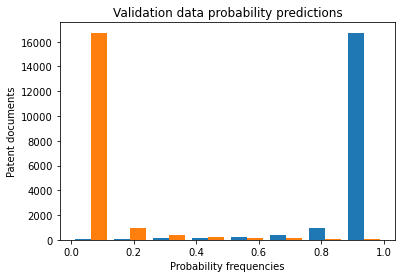

In [45]:
plt.hist(test_predictions_doc2vec_title_abs_prob, bins=8)
plt.title('Validation data probability predictions')
plt.xlabel('Probability frequencies')
plt.ylabel('Patent documents')

plt.show();

In [10]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,test_predictions_doc2vec_title_abs)

array([[16226,   690],
       [  919,   915]])

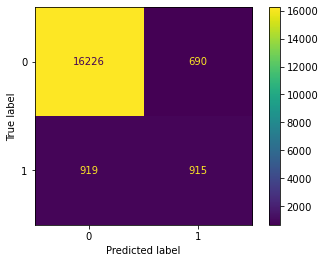

In [18]:
import sklearn.metrics as metrics
metrics.plot_confusion_matrix(clf_title_abs,testing_data_title_abs, y_test);

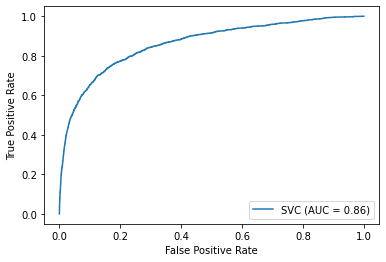

In [19]:
metrics.plot_roc_curve(clf_title_abs,testing_data_title_abs, y_test)  

## SVM

In [8]:
# [TaggedDocument(str(doc).split(), [i, label]) for i, (doc, label) in enumerate(zip(X_train['tac'], y_train))][5]

In [42]:
# Hyperparameter tuning for TITLE & ABSTRACT 
from sklearn import svm

number_iterations = 7

for i in range(number_iterations):

    documents_train_title_abs = [TaggedDocument(str(doc).split(), [i, label]) for i, (doc, label) in enumerate(zip(X_train['title_abs'], y_train))]
    
    # Initialize the model
    doc2vec_model = Doc2Vec(dm=0,
                            vector_size=random.randint(64,200),
                            window=random.randint(2,5),
                            min_count=random.randint(3,5),
                            workers=8,
                            epochs=random.randint(10,50),
                            sample =0 )

    # Build vocab
    doc2vec_model.build_vocab(documents_train_title_abs)

    # Train doc2vec model
    doc2vec_model.train(documents_train_title_abs, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

    # Extract vectors of training data
    doc2vec_df_title_abs = [doc2vec_model[i] for i in range(len(documents_train_title_abs))]

    # Extract vectors of testing data
    testing_data_title_abs = [doc2vec_model.infer_vector(str(document).split()) for document in X_test['title_abs']]

    # SVM Model
    svm_decision_doc2vec = svm.SVC(random_state=42, class_weight='balanced')

    # Fit the model
    clf_title_abs = svm_decision_doc2vec.fit(doc2vec_df_title_abs, y_train)

    test_predictions_doc2vec_title_abs = svm_decision_doc2vec.predict(testing_data_title_abs)

    print(classification_report(y_test,test_predictions_doc2vec_title_abs))

    print('vector_size:'+str(doc2vec_model.vector_size),
          'window:'+str(doc2vec_model.window),
          'min_count:'+str(doc2vec_model.min_count),
        'epochs:'+str(doc2vec_model.epochs))


              precision    recall  f1-score   support

           0       0.96      0.90      0.93     16916
           1       0.41      0.66      0.50      1834

    accuracy                           0.87     18750
   macro avg       0.68      0.78      0.72     18750
weighted avg       0.91      0.87      0.89     18750

vector_size:72 window:5 min_count:5 epochs:33


<ipython-input-42-7b5f46a2f549>:43: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


              precision    recall  f1-score   support

           0       0.95      0.95      0.95     16916
           1       0.53      0.54      0.53      1834

    accuracy                           0.91     18750
   macro avg       0.74      0.74      0.74     18750
weighted avg       0.91      0.91      0.91     18750

vector_size:188 window:5 min_count:4 epochs:48


<ipython-input-42-7b5f46a2f549>:43: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


              precision    recall  f1-score   support

           0       0.95      0.95      0.95     16916
           1       0.54      0.53      0.54      1834

    accuracy                           0.91     18750
   macro avg       0.75      0.74      0.74     18750
weighted avg       0.91      0.91      0.91     18750

vector_size:200 window:4 min_count:4 epochs:35


<ipython-input-42-7b5f46a2f549>:43: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


              precision    recall  f1-score   support

           0       0.95      0.93      0.94     16916
           1       0.48      0.58      0.52      1834

    accuracy                           0.90     18750
   macro avg       0.72      0.76      0.73     18750
weighted avg       0.91      0.90      0.90     18750

vector_size:139 window:3 min_count:4 epochs:44


<ipython-input-42-7b5f46a2f549>:43: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


              precision    recall  f1-score   support

           0       0.96      0.92      0.94     16916
           1       0.46      0.61      0.53      1834

    accuracy                           0.89     18750
   macro avg       0.71      0.77      0.73     18750
weighted avg       0.91      0.89      0.90     18750

vector_size:115 window:4 min_count:5 epochs:43


<ipython-input-42-7b5f46a2f549>:43: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


              precision    recall  f1-score   support

           0       0.95      0.93      0.94     16916
           1       0.48      0.58      0.53      1834

    accuracy                           0.90     18750
   macro avg       0.72      0.76      0.73     18750
weighted avg       0.91      0.90      0.90     18750

vector_size:122 window:2 min_count:4 epochs:27


<ipython-input-42-7b5f46a2f549>:43: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


              precision    recall  f1-score   support

           0       0.95      0.93      0.94     16916
           1       0.48      0.59      0.53      1834

    accuracy                           0.90     18750
   macro avg       0.72      0.76      0.74     18750
weighted avg       0.91      0.90      0.90     18750

vector_size:126 window:4 min_count:3 epochs:36


<ipython-input-42-7b5f46a2f549>:43: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


In [23]:
# Hyperparameter tuning for TITLE
from sklearn import svm

number_iterations = 7

for i in range(number_iterations):
    
    documents_train_title = [TaggedDocument(str(doc).split(), [i, label]) for i, (doc, label) in enumerate(zip(X_train['title'], y_train))]
     
    # Initialize the model
    doc2vec_model = Doc2Vec(dm=0,
                            vector_size=random.randint(64,200),
                            window=random.randint(2,5),
                            min_count=random.randint(3,5),
                            workers=8,
                            epochs=random.randint(10,50))
    
    # Build vocab
    doc2vec_model.build_vocab(documents_train_title)
    
    # Train doc2vec model
    doc2vec_model.train(documents_train_title, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)
    
    # Extract vectors of training data
    doc2vec_df_title = [doc2vec_model[i] for i in range(len(documents_train_title))]
    
    # Extract vectors of testing data
    testing_data_title = [doc2vec_model.infer_vector(str(document).split()) for document in X_test['title']]
    
    # Algorithm
    svm_decision_doc2vec = svm.SVC(random_state = 42,class_weight='balanced')
    
    # Fit the model
    clf_title = svm_decision_doc2vec.fit(doc2vec_df_title, y_train)
    
    test_predictions_doc2vec_title = svm_decision_doc2vec.predict(testing_data_title)
    
    print('dm:'+str(doc2vec_model.dm),
          'vector_size:'+str(doc2vec_model.vector_size),
          'window:'+str(doc2vec_model.window),
          'min_count:'+str(doc2vec_model.min_count),
          'workers:'+str(doc2vec_model.workers),
          'epochs:'+str(doc2vec_model.epochs))
    print(classification_report(y_test,test_predictions_doc2vec_title))

<ipython-input-23-9d945dfff4bb>:41: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


dm:False vector_size:100 window:5 min_count:4 workers:8 epochs:41
              precision    recall  f1-score   support

           0       0.92      0.80      0.86     13598
           1       0.14      0.30      0.19      1402

    accuracy                           0.76     15000
   macro avg       0.53      0.55      0.52     15000
weighted avg       0.84      0.76      0.79     15000



<ipython-input-23-9d945dfff4bb>:41: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


dm:False vector_size:118 window:4 min_count:3 workers:8 epochs:43
              precision    recall  f1-score   support

           0       0.92      0.74      0.82     13598
           1       0.13      0.37      0.19      1402

    accuracy                           0.71     15000
   macro avg       0.52      0.55      0.50     15000
weighted avg       0.84      0.71      0.76     15000



<ipython-input-23-9d945dfff4bb>:41: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


dm:False vector_size:67 window:3 min_count:4 workers:8 epochs:26
              precision    recall  f1-score   support

           0       0.93      0.69      0.79     13598
           1       0.15      0.52      0.23      1402

    accuracy                           0.67     15000
   macro avg       0.54      0.61      0.51     15000
weighted avg       0.86      0.67      0.74     15000



<ipython-input-23-9d945dfff4bb>:41: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


dm:False vector_size:108 window:4 min_count:3 workers:8 epochs:48
              precision    recall  f1-score   support

           0       0.92      0.81      0.86     13598
           1       0.15      0.32      0.20      1402

    accuracy                           0.76     15000
   macro avg       0.53      0.57      0.53     15000
weighted avg       0.85      0.76      0.80     15000



<ipython-input-23-9d945dfff4bb>:41: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


dm:False vector_size:137 window:2 min_count:5 workers:8 epochs:36
              precision    recall  f1-score   support

           0       0.92      0.90      0.91     13598
           1       0.20      0.23      0.21      1402

    accuracy                           0.84     15000
   macro avg       0.56      0.57      0.56     15000
weighted avg       0.85      0.84      0.85     15000



<ipython-input-23-9d945dfff4bb>:41: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


dm:False vector_size:194 window:5 min_count:4 workers:8 epochs:34
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     13598
           1       0.20      0.19      0.20      1402

    accuracy                           0.85     15000
   macro avg       0.56      0.56      0.56     15000
weighted avg       0.85      0.85      0.85     15000

dm:False vector_size:158 window:5 min_count:4 workers:8 epochs:30
              precision    recall  f1-score   support

           0       0.92      0.80      0.85     13598
           1       0.15      0.36      0.21      1402

    accuracy                           0.75     15000
   macro avg       0.54      0.58      0.53     15000
weighted avg       0.85      0.75      0.79     15000



<ipython-input-23-9d945dfff4bb>:41: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


In [24]:
# Hyperparameter tuning for ABSTRACT
from sklearn import svm

number_iterations = 7

for i in range(number_iterations):
    
    documents_train_abs = [TaggedDocument(str(doc).split(), [i, label]) for i, (doc, label) in enumerate(zip(X_train['abstract'], y_train))]
     
    # Initialize the model
    doc2vec_model = Doc2Vec(dm=0,
                            vector_size=random.randint(64,200),
                            window=random.randint(2,5),
                            min_count=random.randint(3,5),
                            workers=8,
                            epochs=random.randint(10,50))
    
    # Build vocab
    doc2vec_model.build_vocab(documents_train_abs)
    
    # Train doc2vec model
    doc2vec_model.train(documents_train_title, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)
    
    # Extract vectors of training data
    doc2vec_df_abs = [doc2vec_model[i] for i in range(len(documents_train_abs))]
    
    # Extract vectors of testing data
    testing_data_abs = [doc2vec_model.infer_vector(str(document).split()) for document in X_test['abstract']]
    
    # Algorithm
    svm_decision_doc2vec = svm.SVC(random_state = 42,class_weight='balanced')
    
    # Fit the model
    clf_title = svm_decision_doc2vec.fit(doc2vec_df_abs, y_train)
    
    test_predictions_doc2vec_abs = svm_decision_doc2vec.predict(testing_data_abs)
    
    print('dm:'+str(doc2vec_model.dm),
          'vector_size:'+str(doc2vec_model.vector_size),
          'window:'+str(doc2vec_model.window),
          'min_count:'+str(doc2vec_model.min_count),
          'workers:'+str(doc2vec_model.workers),
          'epochs:'+str(doc2vec_model.epochs))
    print(classification_report(y_test,test_predictions_doc2vec_abs))

<ipython-input-24-2036f07de884>:41: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


dm:False vector_size:71 window:3 min_count:5 workers:8 epochs:29
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     13598
           1       0.25      0.01      0.01      1402

    accuracy                           0.91     15000
   macro avg       0.58      0.50      0.48     15000
weighted avg       0.85      0.91      0.86     15000



<ipython-input-24-2036f07de884>:41: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


dm:False vector_size:179 window:4 min_count:3 workers:8 epochs:44
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     13598
           1       0.33      0.00      0.00      1402

    accuracy                           0.91     15000
   macro avg       0.62      0.50      0.48     15000
weighted avg       0.85      0.91      0.86     15000



<ipython-input-24-2036f07de884>:41: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


dm:False vector_size:172 window:3 min_count:4 workers:8 epochs:17
              precision    recall  f1-score   support

           0       0.95      0.63      0.76     13598
           1       0.16      0.67      0.26      1402

    accuracy                           0.64     15000
   macro avg       0.55      0.65      0.51     15000
weighted avg       0.88      0.64      0.71     15000



<ipython-input-24-2036f07de884>:41: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


dm:False vector_size:181 window:2 min_count:4 workers:8 epochs:39
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     13598
           1       0.33      0.00      0.00      1402

    accuracy                           0.91     15000
   macro avg       0.62      0.50      0.48     15000
weighted avg       0.85      0.91      0.86     15000



<ipython-input-24-2036f07de884>:41: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


dm:False vector_size:65 window:2 min_count:3 workers:8 epochs:50
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     13598
           1       0.00      0.00      0.00      1402

    accuracy                           0.91     15000
   macro avg       0.45      0.50      0.48     15000
weighted avg       0.82      0.91      0.86     15000



<ipython-input-24-2036f07de884>:41: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


dm:False vector_size:173 window:3 min_count:4 workers:8 epochs:16
              precision    recall  f1-score   support

           0       0.95      0.60      0.74     13598
           1       0.15      0.69      0.25      1402

    accuracy                           0.61     15000
   macro avg       0.55      0.65      0.49     15000
weighted avg       0.88      0.61      0.69     15000

dm:False vector_size:141 window:4 min_count:4 workers:8 epochs:50
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     13598
           1       0.50      0.00      0.00      1402

    accuracy                           0.91     15000
   macro avg       0.70      0.50      0.48     15000
weighted avg       0.87      0.91      0.86     15000



<ipython-input-24-2036f07de884>:41: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


In [25]:
# Hyperparameter tuning for CLAIMS
from sklearn import svm

number_iterations = 7

for i in range(number_iterations):
    
    documents_train_claims = [TaggedDocument(str(doc).split(), [i, label]) for i, (doc, label) in enumerate(zip(X_train['claims'], y_train))]
     
     # Initialize the model
    doc2vec_model = Doc2Vec(dm=0,
                            vector_size=random.randint(64,200),
                            window=random.randint(2,5),
                            min_count=random.randint(3,5),
                            workers=8,
                            epochs=random.randint(10,50))

    # Build vocab
    doc2vec_model.build_vocab(documents_train_claims)

    # Train doc2vec model
    doc2vec_model.train(documents_train_claims, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

    # Extract vectors of training data
    doc2vec_df_claims = [doc2vec_model[i] for i in range(len(documents_train_claims))]

    # Extract vectors of testing data
    testing_data_claims = [doc2vec_model.infer_vector(str(document).split()) for document in X_test['claims']]

    # SVM Model
    svm_decision_doc2vec = svm.SVC(random_state = 42,class_weight='balanced')

    # Fit the model
    clf_claims = svm_decision_doc2vec.fit(doc2vec_df_claims, y_train)

    test_predictions_doc2vec_claims = svm_decision_doc2vec.predict(testing_data_claims)

    print(classification_report(y_test,test_predictions_doc2vec_claims))
    
    print('dm:'+str(doc2vec_model.dm),
          'vector_size:'+str(doc2vec_model.vector_size),
          'window:'+str(doc2vec_model.window),
          'min_count:'+str(doc2vec_model.min_count),
          'workers:'+str(doc2vec_model.workers),
          'epochs:'+str(doc2vec_model.epochs))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93     13598
           1       0.39      0.58      0.46      1402

    accuracy                           0.88     15000
   macro avg       0.67      0.74      0.70     15000
weighted avg       0.90      0.88      0.89     15000

dm:False vector_size:83 window:3 min_count:3 workers:8 epochs:50


<ipython-input-25-8f1285974932>:43: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


              precision    recall  f1-score   support

           0       0.94      0.95      0.95     13598
           1       0.47      0.42      0.44      1402

    accuracy                           0.90     15000
   macro avg       0.70      0.68      0.69     15000
weighted avg       0.90      0.90      0.90     15000

dm:False vector_size:185 window:5 min_count:5 workers:8 epochs:39


<ipython-input-25-8f1285974932>:43: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


              precision    recall  f1-score   support

           0       0.95      0.93      0.94     13598
           1       0.42      0.52      0.47      1402

    accuracy                           0.89     15000
   macro avg       0.68      0.72      0.70     15000
weighted avg       0.90      0.89      0.89     15000

dm:False vector_size:114 window:5 min_count:5 workers:8 epochs:43


<ipython-input-25-8f1285974932>:43: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


              precision    recall  f1-score   support

           0       0.95      0.94      0.94     13598
           1       0.44      0.48      0.46      1402

    accuracy                           0.89     15000
   macro avg       0.69      0.71      0.70     15000
weighted avg       0.90      0.89      0.90     15000

dm:False vector_size:157 window:5 min_count:4 workers:8 epochs:33


<ipython-input-25-8f1285974932>:43: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


              precision    recall  f1-score   support

           0       0.95      0.93      0.94     13598
           1       0.42      0.51      0.46      1402

    accuracy                           0.89     15000
   macro avg       0.69      0.72      0.70     15000
weighted avg       0.90      0.89      0.89     15000

dm:False vector_size:129 window:2 min_count:3 workers:8 epochs:32


<ipython-input-25-8f1285974932>:43: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


              precision    recall  f1-score   support

           0       0.95      0.93      0.94     13598
           1       0.43      0.53      0.47      1402

    accuracy                           0.89     15000
   macro avg       0.69      0.73      0.71     15000
weighted avg       0.90      0.89      0.90     15000

dm:False vector_size:121 window:2 min_count:3 workers:8 epochs:39


<ipython-input-25-8f1285974932>:43: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


              precision    recall  f1-score   support

           0       0.96      0.89      0.92     13598
           1       0.37      0.63      0.47      1402

    accuracy                           0.87     15000
   macro avg       0.67      0.76      0.70     15000
weighted avg       0.90      0.87      0.88     15000

dm:False vector_size:72 window:5 min_count:4 workers:8 epochs:19


<ipython-input-25-8f1285974932>:43: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


In [26]:
# Hyperparameter tuning for ABSTRACT & CLAIMS
from sklearn import svm

number_iterations = 7

for i in range(number_iterations):
    
    documents_train_abs_claims = [TaggedDocument(str(doc).split(), [i, label]) for i, (doc, label) in enumerate(zip(X_train['abs_claims'], y_train))]
     
     # Initialize the model
    doc2vec_model = Doc2Vec(dm=0,
                            vector_size=random.randint(64,200),
                            window=random.randint(2,5),
                            min_count=random.randint(3,5),
                            workers=8,
                            epochs=random.randint(10,50))

    # Build vocab
    doc2vec_model.build_vocab(documents_train_abs_claims)

    # Train doc2vec model
    doc2vec_model.train(documents_train_abs_claims, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

    # Extract vectors of training data
    doc2vec_df_abs_claims = [doc2vec_model[i] for i in range(len(documents_train_abs_claims))]

    # Extract vectors of testing data
    testing_data_abs_claims = [doc2vec_model.infer_vector(str(document).split()) for document in X_test['abs_claims']]


    # SVM Model
    svm_decision_doc2vec = svm.SVC(random_state = 42,class_weight='balanced')

    # Fit the model
    clf_abs_claims = svm_decision_doc2vec.fit(doc2vec_df_abs_claims, y_train)

    test_predictions_doc2vec_abs_claims = svm_decision_doc2vec.predict(testing_data_abs_claims)

    print(classification_report(y_test,test_predictions_doc2vec_abs_claims))

    print('dm:'+str(doc2vec_model.dm),
          'vector_size:'+str(doc2vec_model.vector_size),
          'window:'+str(doc2vec_model.window),
          'min_count:'+str(doc2vec_model.min_count),
          'workers:'+str(doc2vec_model.workers),
          'epochs:'+str(doc2vec_model.epochs))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94     13598
           1       0.42      0.54      0.47      1402

    accuracy                           0.89     15000
   macro avg       0.69      0.73      0.70     15000
weighted avg       0.90      0.89      0.89     15000

dm:False vector_size:115 window:2 min_count:4 workers:8 epochs:28


<ipython-input-26-9ba316d37b91>:44: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


              precision    recall  f1-score   support

           0       0.95      0.94      0.94     13598
           1       0.46      0.51      0.49      1402

    accuracy                           0.90     15000
   macro avg       0.71      0.72      0.71     15000
weighted avg       0.90      0.90      0.90     15000

dm:False vector_size:198 window:3 min_count:4 workers:8 epochs:20


<ipython-input-26-9ba316d37b91>:44: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


              precision    recall  f1-score   support

           0       0.95      0.93      0.94     13598
           1       0.45      0.57      0.50      1402

    accuracy                           0.89     15000
   macro avg       0.70      0.75      0.72     15000
weighted avg       0.91      0.89      0.90     15000

dm:False vector_size:163 window:5 min_count:4 workers:8 epochs:15


<ipython-input-26-9ba316d37b91>:44: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


              precision    recall  f1-score   support

           0       0.94      0.94      0.94     13598
           1       0.44      0.47      0.45      1402

    accuracy                           0.90     15000
   macro avg       0.69      0.70      0.70     15000
weighted avg       0.90      0.90      0.90     15000

dm:False vector_size:139 window:5 min_count:4 workers:8 epochs:42


<ipython-input-26-9ba316d37b91>:44: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


              precision    recall  f1-score   support

           0       0.95      0.93      0.94     13598
           1       0.42      0.49      0.45      1402

    accuracy                           0.89     15000
   macro avg       0.68      0.71      0.70     15000
weighted avg       0.90      0.89      0.89     15000

dm:False vector_size:120 window:3 min_count:3 workers:8 epochs:46


<ipython-input-26-9ba316d37b91>:44: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


              precision    recall  f1-score   support

           0       0.95      0.93      0.94     13598
           1       0.42      0.52      0.46      1402

    accuracy                           0.89     15000
   macro avg       0.68      0.72      0.70     15000
weighted avg       0.90      0.89      0.89     15000

dm:False vector_size:111 window:5 min_count:3 workers:8 epochs:39


<ipython-input-26-9ba316d37b91>:44: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


              precision    recall  f1-score   support

           0       0.96      0.88      0.92     13598
           1       0.37      0.66      0.48      1402

    accuracy                           0.86     15000
   macro avg       0.67      0.77      0.70     15000
weighted avg       0.91      0.86      0.88     15000

dm:False vector_size:66 window:5 min_count:4 workers:8 epochs:14


<ipython-input-26-9ba316d37b91>:44: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


In [27]:
# Hyperparameter tuning for TITLE & CLAIMS
from sklearn import svm

number_iterations = 7

for i in range(number_iterations):
    
    documents_train_title_claims = [TaggedDocument(str(doc).split(), [i, label]) for i, (doc, label) in enumerate(zip(X_train['title_claims'], y_train))]
     
     # Initialize the model
    doc2vec_model = Doc2Vec(dm=0,
                            vector_size=random.randint(64,200),
                            window=random.randint(2,5),
                            min_count=random.randint(3,5),
                            workers=8,
                            epochs=random.randint(10,50))

    # Build vocab
    doc2vec_model.build_vocab(documents_train_title_claims)

    # Train doc2vec model
    doc2vec_model.train(documents_train_title_claims, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

    # Extract vectors of training data
    doc2vec_df_title_claims = [doc2vec_model[i] for i in range(len(documents_train_title_claims))]

    # Extract vectors of testing data
    testing_data_title_claims = [doc2vec_model.infer_vector(str(document).split()) for document in X_test['title_claims']]


    # SVM Model
    svm_decision_doc2vec = svm.SVC(random_state = 42,class_weight='balanced')

    # Fit the model
    clf_title_claims = svm_decision_doc2vec.fit(doc2vec_df_title_claims, y_train)

    test_predictions_doc2vec_title_claims = svm_decision_doc2vec.predict(testing_data_title_claims)

    print(classification_report(y_test,test_predictions_doc2vec_title_claims))

    print('dm:'+str(doc2vec_model.dm),
          'vector_size:'+str(doc2vec_model.vector_size),
          'window:'+str(doc2vec_model.window),
          'min_count:'+str(doc2vec_model.min_count),
          'workers:'+str(doc2vec_model.workers),
          'epochs:'+str(doc2vec_model.epochs))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94     13598
           1       0.44      0.51      0.47      1402

    accuracy                           0.89     15000
   macro avg       0.70      0.72      0.71     15000
weighted avg       0.90      0.89      0.90     15000

dm:False vector_size:150 window:4 min_count:3 workers:8 epochs:29


<ipython-input-27-ea736c2e7115>:44: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


              precision    recall  f1-score   support

           0       0.95      0.92      0.94     13598
           1       0.43      0.57      0.49      1402

    accuracy                           0.89     15000
   macro avg       0.69      0.74      0.71     15000
weighted avg       0.91      0.89      0.90     15000

dm:False vector_size:141 window:4 min_count:3 workers:8 epochs:15


<ipython-input-27-ea736c2e7115>:44: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


              precision    recall  f1-score   support

           0       0.94      0.95      0.94     13598
           1       0.46      0.45      0.45      1402

    accuracy                           0.90     15000
   macro avg       0.70      0.70      0.70     15000
weighted avg       0.90      0.90      0.90     15000

dm:False vector_size:183 window:4 min_count:4 workers:8 epochs:34


<ipython-input-27-ea736c2e7115>:44: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


              precision    recall  f1-score   support

           0       0.96      0.89      0.92     13598
           1       0.37      0.65      0.47      1402

    accuracy                           0.87     15000
   macro avg       0.67      0.77      0.70     15000
weighted avg       0.91      0.87      0.88     15000

dm:False vector_size:70 window:4 min_count:5 workers:8 epochs:14


<ipython-input-27-ea736c2e7115>:44: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


              precision    recall  f1-score   support

           0       0.95      0.94      0.94     13598
           1       0.45      0.49      0.47      1402

    accuracy                           0.90     15000
   macro avg       0.70      0.72      0.71     15000
weighted avg       0.90      0.90      0.90     15000

dm:False vector_size:170 window:3 min_count:3 workers:8 epochs:28


<ipython-input-27-ea736c2e7115>:44: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


              precision    recall  f1-score   support

           0       0.96      0.89      0.92     13598
           1       0.38      0.65      0.48      1402

    accuracy                           0.87     15000
   macro avg       0.67      0.77      0.70     15000
weighted avg       0.91      0.87      0.88     15000

dm:False vector_size:65 window:5 min_count:5 workers:8 epochs:21


<ipython-input-27-ea736c2e7115>:44: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


              precision    recall  f1-score   support

           0       0.95      0.93      0.94     13598
           1       0.43      0.50      0.46      1402

    accuracy                           0.89     15000
   macro avg       0.69      0.72      0.70     15000
weighted avg       0.90      0.89      0.90     15000

dm:False vector_size:132 window:2 min_count:5 workers:8 epochs:50


<ipython-input-27-ea736c2e7115>:44: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


In [28]:
# Hyperparameter tuning for TITLE & ABSTRACT clamis
from sklearn import svm

number_iterations = 7

for i in range(number_iterations):
    
    documents_train_tac = [TaggedDocument(str(doc).split(), [i, label]) for i, (doc, label) in enumerate(zip(X_train['tac'], y_train))]
     
     # Initialize the model
    doc2vec_model = Doc2Vec(dm=0,
                            vector_size=random.randint(64,200),
                            window=random.randint(2,5),
                            min_count=random.randint(3,5),
                            workers=8,
                            epochs=random.randint(10,50))

    # Build vocab
    doc2vec_model.build_vocab(documents_train_tac)

    # Train doc2vec model
    doc2vec_model.train(documents_train_tac, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

    # Extract vectors of training data
    doc2vec_df_tac = [doc2vec_model[i] for i in range(len(documents_train_tac))]

    # Extract vectors of testing data
    testing_data_tac = [doc2vec_model.infer_vector(str(document).split()) for document in X_test['tac']]


    # SVM Model
    svm_decision_doc2vec = svm.SVC(random_state = 42,class_weight='balanced')

    # Fit the model
    clf_tac = svm_decision_doc2vec.fit(doc2vec_df_tac, y_train)

    test_predictions_doc2vec_tac = svm_decision_doc2vec.predict(testing_data_tac)

    print(classification_report(y_test,test_predictions_doc2vec_tac))

    print('dm:'+str(doc2vec_model.dm),
          'vector_size:'+str(doc2vec_model.vector_size),
          'window:'+str(doc2vec_model.window),
          'min_count:'+str(doc2vec_model.min_count),
          'workers:'+str(doc2vec_model.workers),
          'epochs:'+str(doc2vec_model.epochs))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     13598
           1       0.47      0.43      0.45      1402

    accuracy                           0.90     15000
   macro avg       0.70      0.69      0.70     15000
weighted avg       0.90      0.90      0.90     15000

dm:False vector_size:159 window:5 min_count:3 workers:8 epochs:40


<ipython-input-28-75e9210087a5>:44: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


              precision    recall  f1-score   support

           0       0.95      0.94      0.94     13598
           1       0.45      0.47      0.46      1402

    accuracy                           0.90     15000
   macro avg       0.70      0.70      0.70     15000
weighted avg       0.90      0.90      0.90     15000

dm:False vector_size:130 window:5 min_count:4 workers:8 epochs:49


<ipython-input-28-75e9210087a5>:44: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


              precision    recall  f1-score   support

           0       0.94      0.95      0.94     13598
           1       0.46      0.42      0.44      1402

    accuracy                           0.90     15000
   macro avg       0.70      0.69      0.69     15000
weighted avg       0.90      0.90      0.90     15000

dm:False vector_size:149 window:5 min_count:4 workers:8 epochs:47


<ipython-input-28-75e9210087a5>:44: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


              precision    recall  f1-score   support

           0       0.96      0.89      0.92     13598
           1       0.38      0.64      0.48      1402

    accuracy                           0.87     15000
   macro avg       0.67      0.77      0.70     15000
weighted avg       0.91      0.87      0.88     15000

dm:False vector_size:65 window:5 min_count:3 workers:8 epochs:24


<ipython-input-28-75e9210087a5>:44: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


              precision    recall  f1-score   support

           0       0.95      0.93      0.94     13598
           1       0.44      0.51      0.48      1402

    accuracy                           0.89     15000
   macro avg       0.70      0.72      0.71     15000
weighted avg       0.90      0.89      0.90     15000

dm:False vector_size:121 window:5 min_count:3 workers:8 epochs:36


<ipython-input-28-75e9210087a5>:44: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


              precision    recall  f1-score   support

           0       0.96      0.90      0.93     13598
           1       0.38      0.61      0.47      1402

    accuracy                           0.87     15000
   macro avg       0.67      0.75      0.70     15000
weighted avg       0.90      0.87      0.88     15000

dm:False vector_size:72 window:2 min_count:5 workers:8 epochs:40


<ipython-input-28-75e9210087a5>:44: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


              precision    recall  f1-score   support

           0       0.95      0.94      0.94     13598
           1       0.44      0.47      0.46      1402

    accuracy                           0.89     15000
   macro avg       0.69      0.71      0.70     15000
weighted avg       0.90      0.89      0.90     15000

dm:False vector_size:137 window:2 min_count:3 workers:8 epochs:38


<ipython-input-28-75e9210087a5>:44: DeprecationWarning: Call to deprecated `min_count` (Attribute will be removed in 4.0.0, use self.vocabulary.min_count instead).
  'min_count:'+str(doc2vec_model.min_count),


### ROC_AUC Curve for the best performing feature

In [ ]:
from sklearn.metrics import roc_auc_score
# roc_auc_score(y_test.tolist(), y_pred)
roc_title = roc_auc_score(y_test,test_predictions_doc2vec_title)
roc_abs = roc_auc_score(y_test,test_predictions_doc2vec_abs)
roc_claims = roc_auc_score(y_test,test_predictions_doc2vec_claims)
roc_title_abs = roc_auc_score(y_test,test_predictions_doc2vec_title_abs)
roc_title_claims = roc_auc_score(y_test,test_predictions_doc2vec_title_claims)
roc_abs_claims = roc_auc_score(y_test,test_predictions_doc2vec_abs_claims)
roc_tac = roc_auc_score(y_test,test_predictions_doc2vec_tac)

print('ROC_title:', roc_title)
print('ROC_abstract:', roc_abs)
print('ROC_claims:', roc_claims)
print('ROC_title_abstract:', roc_title_abs)
print('ROC_title_claims:', roc_title_claims)
print('ROC_abstract_claims:', roc_abs_claims)
print('ROC_title_claims_abstract:', roc_tac)

In [ ]:
import sklearn.metrics as metrics

metrics.plot_roc_curve(svm_decision_doc2vec, testing_data_tac, y_test);

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf_title, testing_data_title, y_test);